In [1]:
import ComputationalHypergraphDiscovery as chd
import pandas as pd
import pickle

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools


import torch
torch.manual_seed(0)
import numpy as np


import sys
sys.path.append("../")
from shared_casual_discovery import *



In [2]:
# Parameters
N_datapoints = 1500
sigma = 0.1

# Generate the data
# X -> Y
# X -> Z
# Y,Z-> B
# B -> C
X = torch.randn(N_datapoints)
Y = 4 * torch.sin(2 * X) + sigma * torch.randn(N_datapoints)
Z = 3.5 * X**2 + sigma * torch.randn(N_datapoints)
B = Y**2 - Z**2 / 100 + sigma * torch.randn(N_datapoints)
C = 2 * torch.sin(B) + sigma * torch.randn(N_datapoints)

# Stack the data into a single tensor
data = torch.stack([X, Y, Z, B, C], dim=1)

name_to_idx = {"X" : 0, "Y" : 1, "Z" : 2, "B" : 3, "C" : 4}

df = pd.DataFrame(data.numpy(), columns=['X', 'Y', 'Z', 'B', 'C'])
df

,X,Y,Z,B,C
0,-1.125840,-3.067830,4.370651,9.325633,0.016733
1,-1.152360,-2.860869,4.580361,7.944935,2.031671
2,-0.250579,-1.813373,0.153417,3.069329,0.110331
3,-0.433879,-3.111164,0.587666,9.737496,-0.701122
4,0.848710,3.782373,2.491156,14.263285,1.935063
...,...,...,...,...,...
1495,0.403254,3.240962,0.495614,10.383460,-1.694597
1496,0.802490,3.902219,2.322147,15.373322,0.658877
1497,0.262803,2.128708,0.155480,4.623086,-2.091746
1498,0.690109,3.775874,1.733559,14.025502,2.130932


In [53]:


def plot_clean_graph(node_lbls, adj_matrix, title=False, 
                     DAG=False, DAG_edges=None, 
                     ax=None, colormap='viridis', line_styles=None,
                    ):
    nodes = node_lbls
    node_to_idx = { a : i for i,a in zip(range(len(nodes)), nodes)}
    if line_styles is None:
        line_styles = len(nodes)*"-"

    graph = nx.MultiDiGraph()
    graph.add_nodes_from(nodes)
    edge_matrix = find_edges(adj_matrix)
    num_edges = len(edge_matrix)
    edge_labels = {}

    cmap   = plt.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, num_edges))
    edge_styles = line_styles

    for edge, color, style in zip(range(num_edges), itertools.cycle(colors), itertools.cycle(edge_styles)):
        if not DAG:
            source = edge_matrix[edge][0]
            target = edge_matrix[edge][1]
            weight = adj_matrix[source, target]
        else:
            if DAG_edges[edge] < 0:
                source = edge_matrix[edge][1]
                target = edge_matrix[edge][0]
            else:
                source = edge_matrix[edge][0]
                target = edge_matrix[edge][1]
            weight = np.abs(DAG_edges[edge])

        graph.add_edge(nodes[source], nodes[target], weight=weight, color=color, style=style)
        edge_labels[(nodes[source], nodes[target])] = '{0:.2f}'.format(weight)

    # Positioning of nodes
    pos = nx.circular_layout(graph)
    edges = graph.edges(data=True)
    weights = [7 * abs(data['weight']) for _, _, data in edges]

    # Create figure only if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=[15, 9])
        show_plot = True
    else:
        show_plot = False

    nx.draw_networkx_nodes(graph, pos=pos, nodelist=nodes, node_size=500, ax=ax)
    nx.draw_networkx_labels(graph, pos=pos, font_size=10, font_color='white', font_weight="bold", ax=ax)

    # Draw edges with specific styles and colors
    M_dag = np.zeros((len(nodes), len(nodes)))
    for edge, weight, color, style in zip(edges, weights, itertools.cycle(colors), itertools.cycle(edge_styles)):
        nx.draw_networkx_edges(graph, pos=pos, edgelist=[(edge[0], edge[1])], width=min(0.2+weight,weight), 
                               edge_color=color, style=style, node_size=500, arrowsize=10, ax=ax)
        M_dag[node_to_idx[edge[0]], node_to_idx[edge[1]]] = 1 



    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=14, bbox=dict(alpha=0), 
                                 label_pos=0.65, verticalalignment='top', rotate=False, horizontalalignment='left', node_size=500, ax=ax)
    #ax.set_axis_off()

    if title:
        ax.set_title(title)

    if show_plot:
        plt.show()
        plt.close()

    return M_dag


# Helper function to find edges based on the adjacency matrix
def find_edges(adj_matrix):
    rows, cols = np.where(adj_matrix != 0)
    return list(zip(rows, cols))

def plot_model_weights_history(model_weights_hist, title='Model Weights History', 
                               colormap='viridis', line_styles=None, ax=None):
    cmap = plt.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, model_weights_hist.shape[1]))

    if line_styles is None:
        line_styles = len(colors)*"-"
    
    show_plot = False
    if ax is None:
        fig, ax = plt.subplots(figsize=[15, 9])
        show_plot = True

    plt.figure(figsize=(10, 6)) 
    for i, color, style in zip(range(model_weights_hist.shape[1]), colors, itertools.cycle(line_styles)):
        ax.plot(model_weights_hist[:, i], color=color, linestyle=style, label=str(i))
    #plt.legend()
    ax.set_title(title)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Weight Value')
    ax.grid()

    if show_plot:
        plt.show()
        plt.close()


def find_direction(df,
                   M=None,
                   M_dag_ref=None,
                   epochs=2000,
                   pretrain_epochs = 100, pre_lr = 1e-2,
                   d1_weight = 1.0, lr = 1e-1,
                   rng_seed=7,
                   plots=False,
                   save_fig=False,
                   use_noise=True,
                   use_lowest_loss=False,
                   ):

    ## step 1: get adjacency matrix (from CHD runs) ###############################
    attr      = list(df.columns)

    data_tensor = torch.tensor(df.to_numpy()).to(dtype=torch.float64)
    #standarize data
    d_mean = torch.mean(data_tensor, dim=0)
    d_std = torch.std(data_tensor, dim=0) + 1e-10
    data_tensor = (data_tensor - d_mean) / d_std

    ## step 2: build model ########################################################
    #Set seeds for reproducibility
    torch.manual_seed(rng_seed)
    np.random.seed(rng_seed)
    torch.cuda.manual_seed_all(rng_seed)

    model = Reconstruct(M, use_noise=use_noise).to(dtype=torch.float64)

    ## step 2b: pretrain the neural networks ######################################
    pre_losses = pretrain(model, pretrain_epochs, pre_lr, data_tensor)

    # plt.figure()
    # plt.plot(pre_losses)
    # plt.show()



    ## step 3: train from reconstruction ##########################################
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9)

    save_name     = "low_loss.param"
    curr_low_loss = 1e8

    model.train()
    mse_losses = np.zeros(epochs)
    DAG_losses = np.zeros(epochs)
    total_loss = np.zeros(epochs)
    model_weights_hist = np.zeros((epochs,model.weights.detach().flatten().numpy().size))
    num_nodes = np.zeros(epochs)
    for epoch in range(1,epochs+1):
        optimizer.zero_grad()
        model_out = model(data_tensor)
        mse_loss, DAG_loss, num_recon_nodes = model.compute_loss(data_tensor, model_out)
        num_nodes[epoch-1]=num_recon_nodes
        #loss =  mse_loss
        #loss = mse_loss + d1_weight*DAG_loss #this is the original loss
        #loss = (1/num_recon_nodes) * mse_loss + d1_weight*DAG_loss #this is the average mse original loss
        loss = (1/num_recon_nodes) * mse_loss + d1_weight * DAG_loss
        #loss = (1/num_recon_nodes) * mse_loss + (epoch/epochs * 2)*DAG_loss #dynamic DAG loss weight
        loss.backward()
        optimizer.step()
        mse_losses[epoch-1]=mse_loss.detach()
        DAG_losses[epoch-1]=DAG_loss.detach()
        model_weights_hist[epoch-1,:] = model.weights.detach().flatten().numpy()
        total_loss[epoch-1]=loss

        # saving every epoch takes a long time
        if epoch > 25 and epoch % 5 == 0 and curr_low_loss > loss.item():
            torch.save({'epoch': epoch, 'loss': loss, 'model_state_dict': model.state_dict()}, save_name)
            curr_low_loss = loss.item()

    if use_lowest_loss:
        saved_model_dict = torch.load(save_name)
        assert saved_model_dict['loss'] <= curr_low_loss, "lowest loss ewas not saved correctly"
        saved_model_parameters = saved_model_dict['model_state_dict']
        model.load_state_dict(saved_model_parameters)
        epoch = saved_model_dict['epoch']
    ## step 4: post-process #######################################################
    if plots:

        
        fig, axs = plt.subplots(2, 2, figsize=[10, 6], constrained_layout=True)
        axs[0,0].semilogy(mse_losses + d1_weight*DAG_losses, c='b', label="Total loss")
        axs[0,0].semilogy(mse_losses, c='g', label="Reconstruction loss")
        axs[0,0].semilogy(DAG_losses*d1_weight, c='r', label="DAG loss")
        axs[0,0].legend(fontsize='xx-large')
        axs[0,0].set_title("Loss vs epoch")
        #plot_directed_graph(attr, M, title="DAG learned via reconstruction", DAG=True, DAG_edges=model.weights.detach().flatten().numpy()) # reconstructed DAG

        # print("MSE loss ", mse_losses[-1])
        # print("num recon nodes", num_nodes[-1])
        # print("rng seed ", rng_seed)


        init, _ = solve_system(M)
        #plot_directed_graph(attr, M, title="CHD directed graph", DAG=False) # original directed graph from CHD
        #plot_directed_graph(attr, M, title="DAG initalization", DAG=True, DAG_edges=init)
        #plot_directed_graph(attr, M, title="DAG learned via reconstruction", DAG=True, DAG_edges=model.weights.detach().flatten().numpy()) # reconstructed DAG
        #print("final loss: ", mse_losses[-1])

        linestyles = None
        M_chd = plot_clean_graph(attr, M, title="CHD directed graph", DAG=False, ax=axs[0,1])

        
        M_dag  = plot_clean_graph(attr, M, title="learned DAG", DAG=True, 
                                 DAG_edges=model.weights.detach().flatten().numpy(), ax=axs[1,1])

        plot_model_weights_history(model_weights_hist, title='Model Weights History', 
                               colormap='viridis', line_styles=None, ax=axs[1,0])

        fig.tight_layout()
        if save_fig:
            plt.savefig("vdos.pdf")
        plt.show()
        plt.close()


    return mse_losses, model_weights_hist, epoch, M_dag




In [54]:
def create_adjacency_matrix(G, weight_key='signal'):
    # nodes 
    nodes = list(G.nodes())
    n = len(nodes)
    
    adj_matrix = np.zeros((n, n))
    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            if G.has_edge(node_i, node_j):
                adj_matrix[i, j] = G.get_edge_data(node_i, node_j).get(weight_key, 0)
    
    # visualize
    adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)
    print(adj_df)
    return adj_matrix
    

In [55]:

try:
    print("loaded data from disk")
    with open("artificial_graph.p", "rb") as file:
        G = pickle.load(file)
except Exception as e:
    print(e)
    graph_discovery=chd.GraphDiscovery.from_dataframe(df)
    G = graph_discovery.G
    graph_discovery.fit()
    
    pickle.dump(graph_discovery.G, open("artificial_graph.p", "wb"))

    # X -> Y
    # X -> Z
    # Y,Z-> B
    # B -> C
    graph_discovery.plot_graph()


M_dag_ref = torch.zeros((5,5))

M_dag_ref[0,1] = 1 # X->Y
M_dag_ref[0,2] = 1 # X->Z
M_dag_ref[1,3] = 1 # Y->B
M_dag_ref[2,3] = 1 # Z->B
M_dag_ref[3,4] = 1 # B->C
M_dag_ref

loaded data from disk


tensor([[0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [56]:
adj_matrix = create_adjacency_matrix(G)

          X         Y         Z         B         C
X  0.000000  0.175792  0.229685  0.011643  0.000000
Y  0.119583  0.000000  0.000000  0.429936  0.000000
Z  0.097555  0.048911  0.000000  0.009265  0.000000
B  0.000000  0.000000  0.000000  0.000000  0.459243
C  0.000000  0.000000  0.000000  0.000000  0.000000


/var/folders/jc/hbh56n2114d44h5k85mrw9sr003gz4/T/ipykernel_5587/324000489.py:220: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


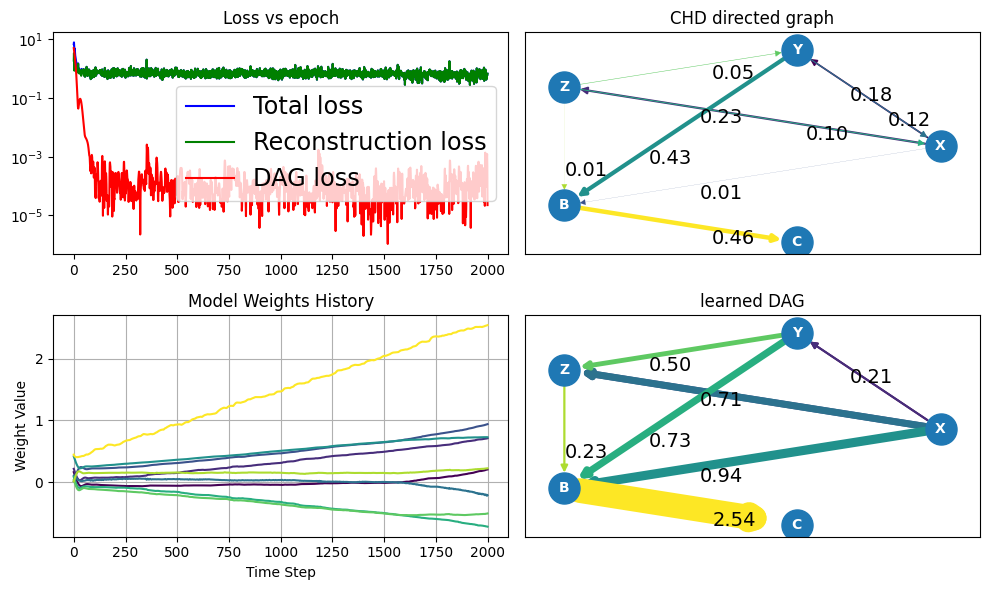

<Figure size 1000x600 with 0 Axes>

In [57]:


pre_lr = 1e-2
lr = 1e-2
use_lowest_loss = False

M = adj_matrix.copy()

mse_losses, model_weights_hist, opt_epoch, M_dag = find_direction(
                    df, 
                    M=M,
                    M_dag_ref=M_dag_ref,
                    epochs=2000,
                    pretrain_epochs = 100, pre_lr = pre_lr,
                    d1_weight = 1.0, lr = lr,
                    rng_seed=7,
                    plots=True,
                    use_lowest_loss=use_lowest_loss
                    )


# M = M + M.T

# mse_losses, model_weights_hist, opt_epoch = find_direction(
#                     df, 
#                     M=M,
#                     epochs=2000,
#                     pretrain_epochs = 100, pre_lr = pre_lr,
#                     d1_weight = 1.0, lr = lr,
#                     rng_seed=7,
#                     plots=True,
#                     use_lowest_loss=use_lowest_loss
#                     )

# M = adj_matrix.copy()
# idx = np.where(M > 0)
# M[idx[0], idx[1]] = 1/len(idx)

# mse_losses, model_weights_hist, opt_epoch = find_direction(
#                     df, 
#                     M=M,
#                     epochs=2000,
#                     pretrain_epochs = 100, pre_lr = pre_lr,
#                     d1_weight = 1.0, lr = lr,
#                     rng_seed=7,
#                     plots=True,
#                     use_lowest_loss=use_lowest_loss
#                     )

# M = adj_matrix.copy()
# idx = np.where(M > 0)
# M[idx[0], idx[1]] = 1

# mse_losses, model_weights_hist, opt_epoch = find_direction(
#                     df, 
#                     M=M,
#                     epochs=2000,
#                     pretrain_epochs = 100, pre_lr = pre_lr,
#                     d1_weight = 1.0, lr = lr,
#                     rng_seed=7,
#                     plots=True,
#                     use_lowest_loss=use_lowest_loss
#                     )


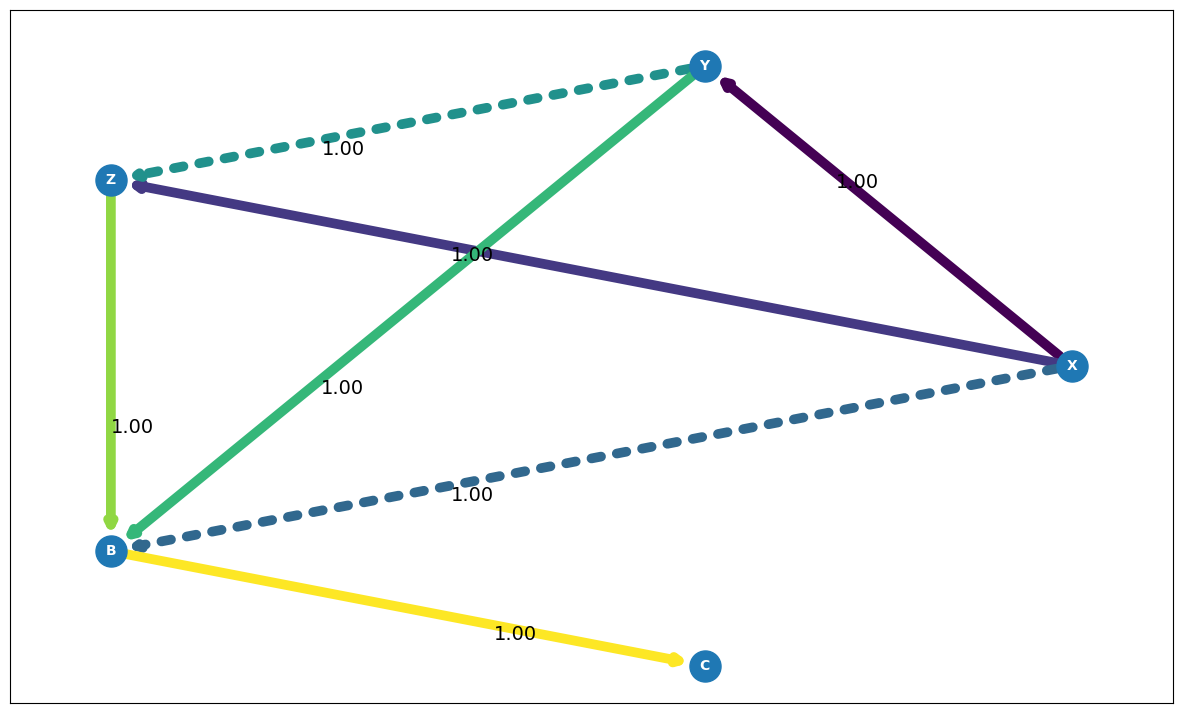

array([[0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [66]:
e_diff = find_edges(M_dag_ref-M_dag)
e_all  = find_edges(M_dag)

line_styles = []

for e_i in e_all:
    if e_i in e_diff:
        line_styles.append(":")
    else:
        line_styles.append("-")
line_styles

plot_clean_graph(list(df.columns), M_dag, title=False, DAG=False, DAG_edges=[2,2], ax=None,
                    colormap='viridis', line_styles=line_styles, )

In [ ]:
# X -> Y
# X -> Z
# Y,Z-> B
# B -> C

############################################
pre_lr=1.0e-01	lr=1.0e-01


/var/folders/jc/hbh56n2114d44h5k85mrw9sr003gz4/T/ipykernel_5587/324000489.py:220: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


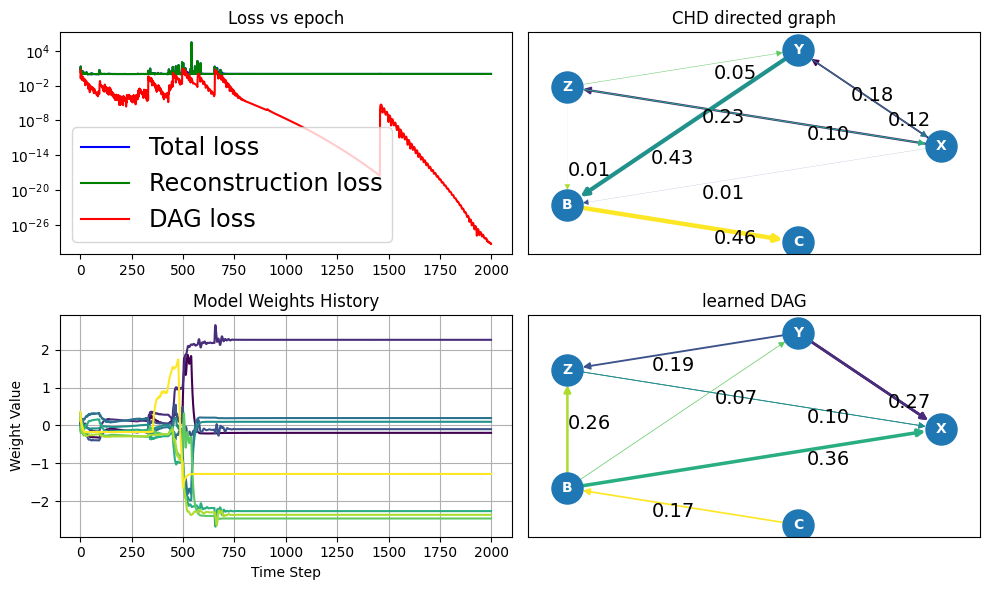

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=1.0e-01	lr=1.0e-02


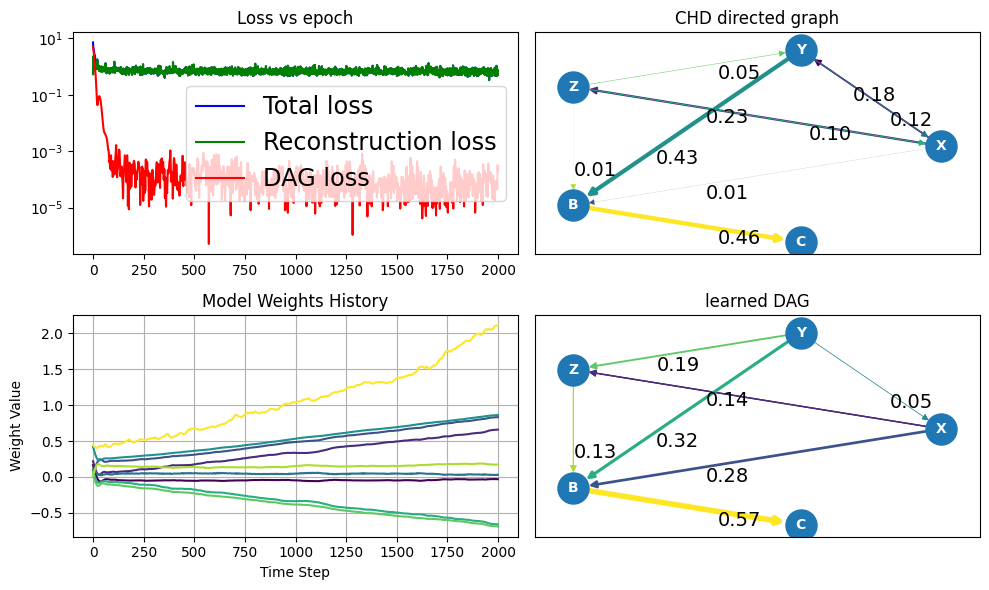

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=1.0e-01	lr=5.0e-03


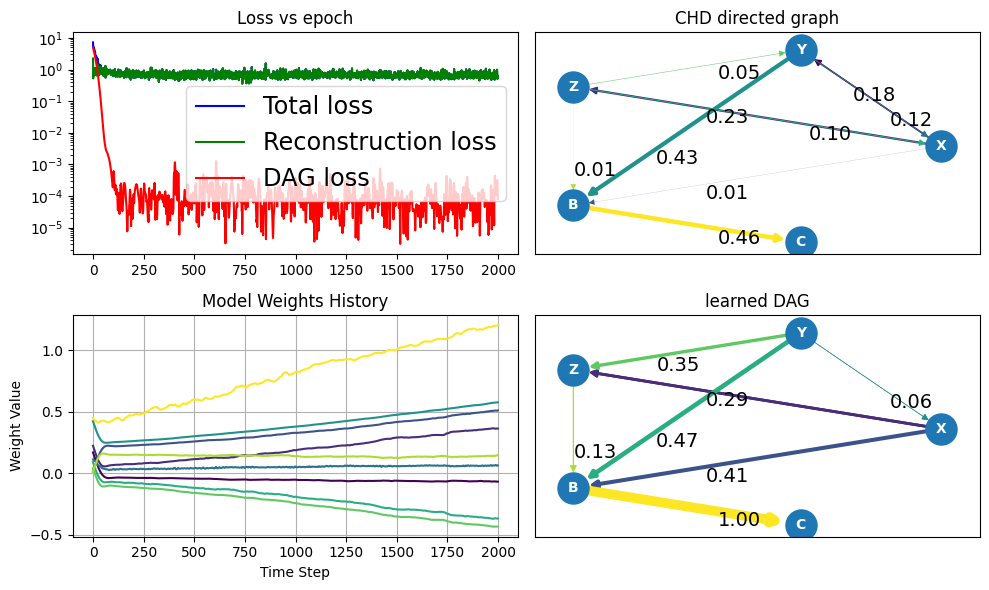

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=1.0e-02	lr=1.0e-01


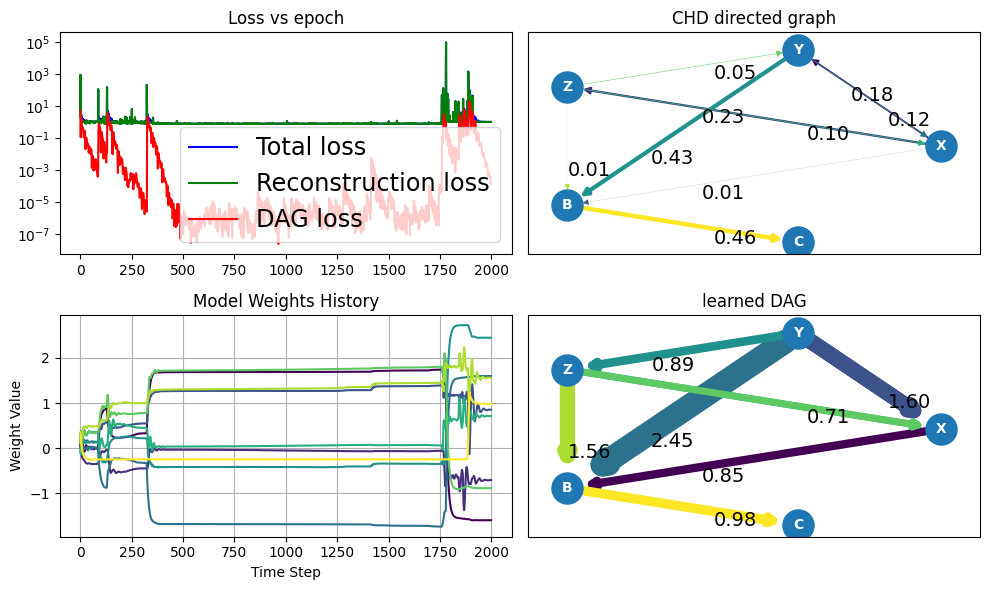

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=1.0e-02	lr=1.0e-02


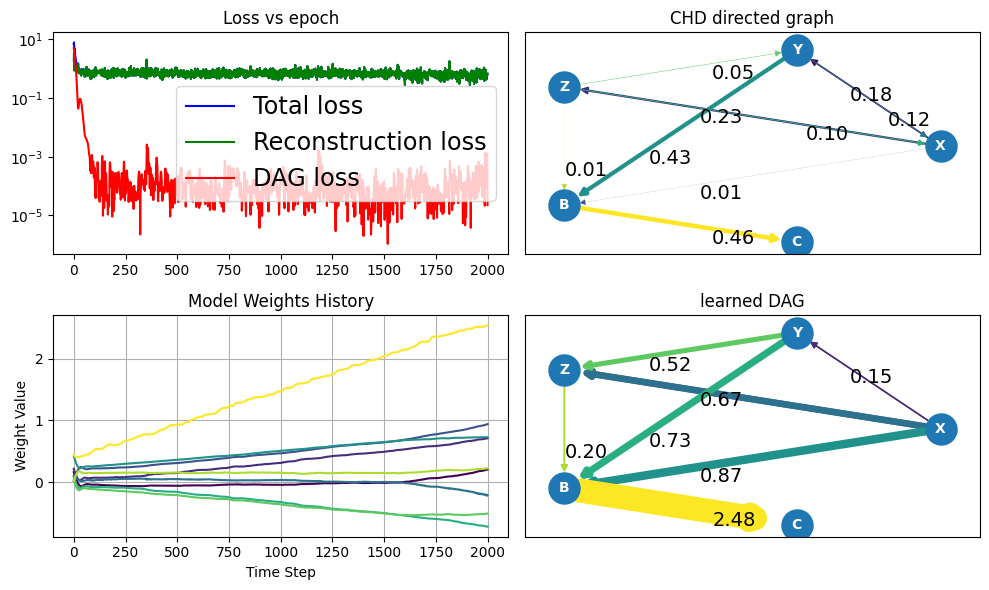

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=1.0e-02	lr=5.0e-03


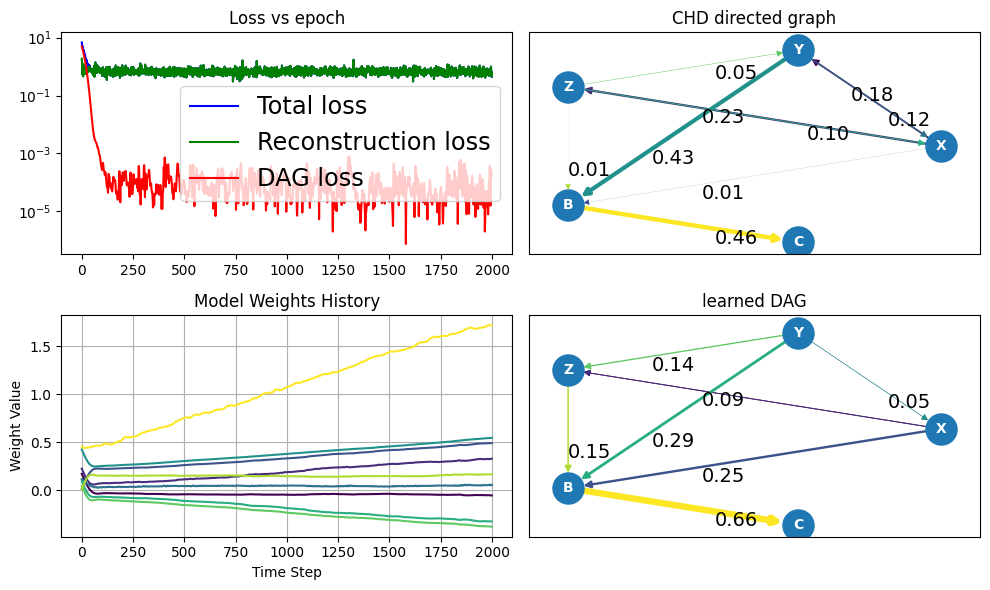

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=5.0e-03	lr=1.0e-01


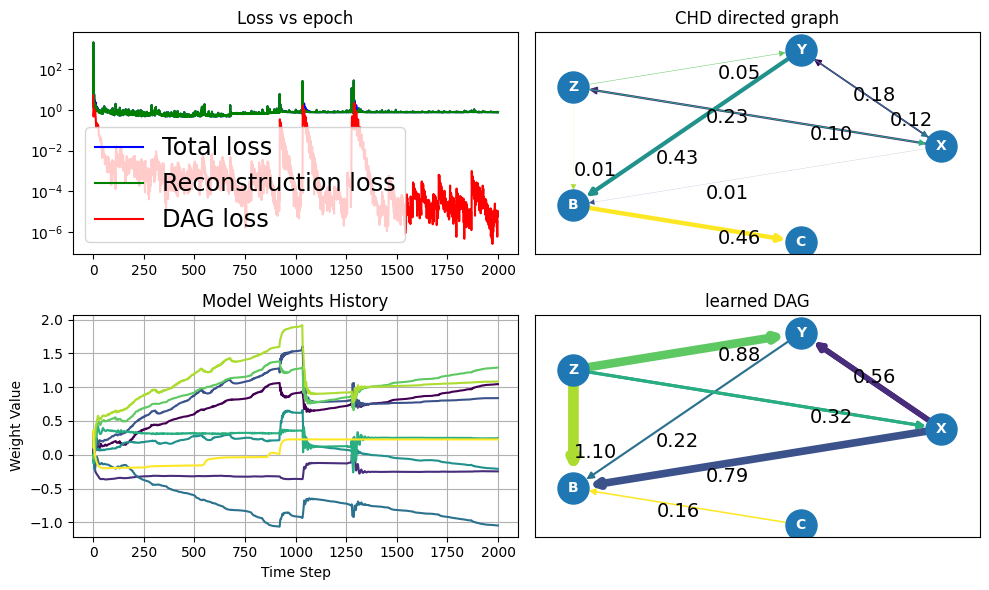

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=5.0e-03	lr=1.0e-02


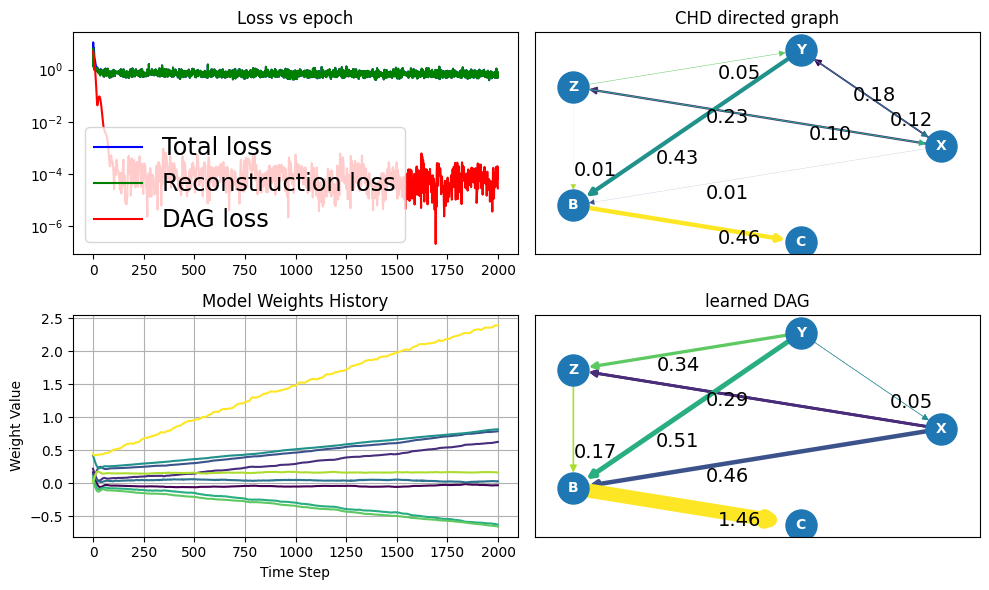

<Figure size 1000x600 with 0 Axes>

############################################
pre_lr=5.0e-03	lr=5.0e-03


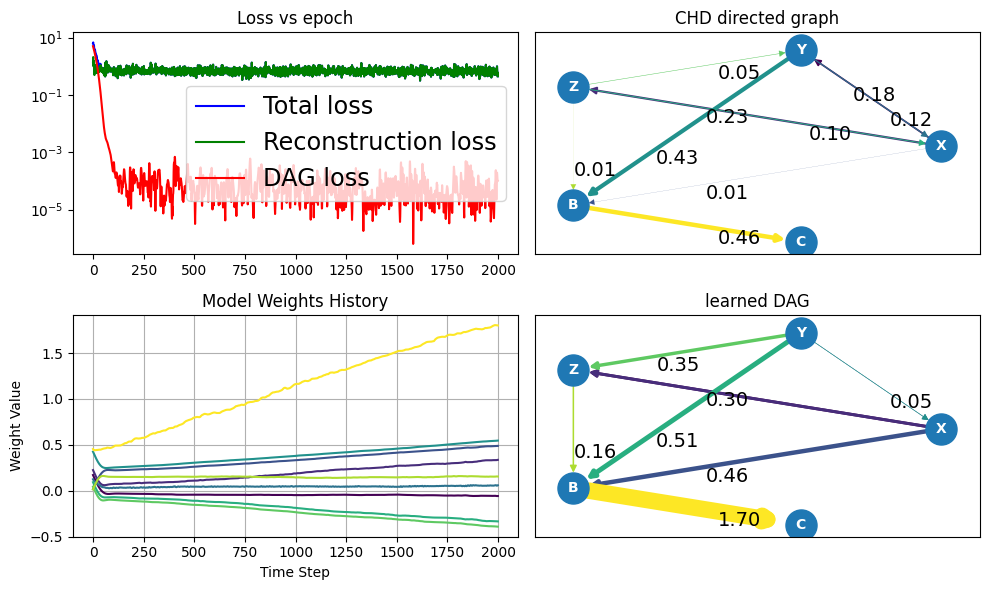

<Figure size 1000x600 with 0 Axes>

In [69]:
use_lowest_loss = True

for pre_lr in [1e-1, 1e-2, 5e-3]:
    for lr in [1e-1, 1e-2, 5e-3]:

        print("############################################")
        print(f"pre_lr={pre_lr:1.1e}\tlr={lr:1.1e}")
    
        M = adj_matrix.copy()
        
        mse_losses, model_weights_hist, opt_epoch, M_dag = find_direction(
                            df, 
                            M=M,
                            epochs=2000,
                            pretrain_epochs = 100, pre_lr = pre_lr,
                            d1_weight = 1.0, lr = lr,
                            rng_seed=7,
                            plots=True,
                            use_lowest_loss=use_lowest_loss
                            )
        